# **_Autonomous and Adaptive Systems_ - 2025**
## **Mini-Project**:*Overcooked* - A2C implementation

### Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow import keras
from tqdm import tqdm
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.planning.planners import MediumLevelActionManager

2025-06-21 17:51:41.109883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Testing _Overcooked_ environment

- `base_mdp` = An MDP grid world based off of the Overcooked game.
- `base_env` = An environment wrapper for the OvercookedGridworld Markov Decision Process. The environment keeps track of the current state of the agent, updates it as the agent takes actions, and provides rewards to the agent.
- `env`= Similar to gym env.

In [2]:
base_mdp = OvercookedGridworld.from_layout_name("cramped_room", old_dynamics = True) # or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=400)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

There are different experimetnal layouts:
- ***Cramped Room*** presents low-level coordination challenges: in this shared, confined space it is very easy for the agents to collide.
- ***Asymmetric Advantages*** tests whether players can choose high-level strategies that play to their strengths.
- ***Coordination Ring***, players must coordinate to travel between the bottom left and top right corners of the layout.
- ***Forced Coordination*** removes collision coordination problems, and forces players to develop a high-level joint strategy, since neither player can serve a dish by themselves.
- ***Counter Circuit*** involves a non-obvious coordination strategy, where onions are passed over the counter to the pot, rather than being carried around.

#### **Actions**

The possible actions are: _up, down, left, right, noop,_ and _"interact"_

In [3]:
print('The action space has dimension: {}'.format(env.action_space))

The action space has dimension: Discrete(6)


#### **Observations**

In [4]:
observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step((action, action))
observation

{'both_agent_obs': (array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  1., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0., -2.,  2.,  0.,  0.,  0.,  0.,  0.,
          2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
          0.,  2., -1.,  1.,  2.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -2.,
          2.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
          1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,

### Understanding the _Overcooked_ **observations** to apply shaping

- `[0:4]` pi_orientation: length 4 one-hot-encoding of direction currently facing
- `[4:8]` pi_obj: length 4 one-hot-encoding of object currently being held (all 0s if no object held) (onion|soup|dish|tomato)
- `[8:20]` pi_closest_{onion|tomato|dish|soup|serving|empty_counter}: (dx, dy) where dx = x dist to item, dy = y dist to item. (0, 0) if item is currently held
- `[20:22]` pi_cloest_soup_n_{onions|tomatoes}: int value for number of this ingredient in closest soup ???
- `[22:23]` pi_closest_pot_{j}_exists: {0, 1} depending on whether jth closest pot found. If 0, then all other pot features are 0. Note: can be 0 even if there are more than j pots on layout, if the pot is not reachable by player i
- `[23:27]` pi_closest_pot_{j}_{is_empty|is_full|is_cooking|is_ready}: {0, 1} depending on boolean value for jth closest pot
- `[27:29]` pi_closest_pot_{j}_{num_onions|num_tomatoes}: int value for number of this ingredient in jth closest pot
- `[29:30]` pi_closest_pot_{j}_cook_time: int value for seconds remaining on soup. -1 if no soup is cooking
- `[30:32]` pi_closest_pot_{j}: (dx, dy) to jth closest pot from player i location
- `[32:36]` pi_wall: length 4 boolean value of whether player i has wall in each direction

In [5]:
class OvercookedRewardShaping(Overcooked):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def step(self, actions):
        observation, base_reward, done, info = super().step(actions)
        if base_reward != 0:
            print("Soup delivered! Voto: {}".format(base_reward)) # base_reward is 20 if soup is delivered
        shaped_reward = base_reward + self._compute_shaping(observation['both_agent_obs'])
        return observation, shaped_reward, done, info

    def _compute_shaping(self, observations):
        shaping = 0
        for obs in observations:
            holding_vector = obs[4:8]
            holding_soup = obs[5:6]
            soup_full_cooking_ready = obs[24:27]
            soup_empty = obs[23:24]
            soup_cooking = obs[25:26]
            pot_onions = obs[27:28]
            
            # Penalty if holding an object
            #if holding_vector.any():
            #    shaping -= 0.05
            # Reward if holding a soup
            #if holding_soup.any():
            #    shaping += 0.1
            # Reward if soup is full/cooking/ready
            if soup_cooking.any():
                shaping += 0.3
            # Reward if onion are putted into the soup
            #if soup_empty.any():
            # shaping += int(pot_onions)*0.01

        return shaping

In [6]:
env = OvercookedRewardShaping(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

#### Testing a random episode

In [7]:
for i_episode in range(1):
    observation = env.reset()
    
    for t in range(100):
        action = env.action_space.sample()
        state = env.step((action, action))

env.close()

### **Networks**

In [8]:
num_inputs = 96 # length of the observation array
num_actions = 6
num_hidden = 128

#### _Actor_ model
- **Actor**: This takes as input the _state of our environment_ and returns a _probability value_ for each action in its action space.

In [9]:
# Actor-Critic for Player 1
actor = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_actions, activation='softmax')
])

actor = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_actions, activation='softmax')
])

actor_optimizer = keras.optimizers.Adam(learning_rate=1e-7)

#### _Critic_ model
- **Critic**: This takes as input the _state of our environment_ and returns an estimate of _total rewards_ in the future.

In [10]:
critic = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden, activation='relu'),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(1)
])

critic = keras.models.Sequential([
    keras.layers.Input(shape=(num_inputs,)),
    keras.layers.Dense(num_hidden//2, activation='relu'),
    keras.layers.Dense(num_hidden//4, activation='relu'),
    keras.layers.Dense(1)
])

critic_optimizer = keras.optimizers.Adam(learning_rate=1e-7)

### **Training**

In [ ]:
seed = 42
gamma = 0.99  # discount factor for past rewards
running_reward = 0

mse_loss = keras.losses.MeanSquaredError()
actor_optimizer = keras.optimizers.Adam(learning_rate=1e-4)
critic_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

#### <u>Update</u>: After each **step**
Implementing the ***One-step Actor-Critic Method*** seen during lecture.

 40%|████      | 4/10 [02:58<04:23, 43.86s/it]

running reward: 1.06 at episode 4 Last actor Loss: -0.30 - Last critic Loss: 0.03


 90%|█████████ | 9/10 [06:27<00:41, 41.25s/it]

running reward: 1.85 at episode 9 Last actor Loss: -0.18 - Last critic Loss: 0.03


100%|██████████| 10/10 [07:05<00:00, 42.53s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

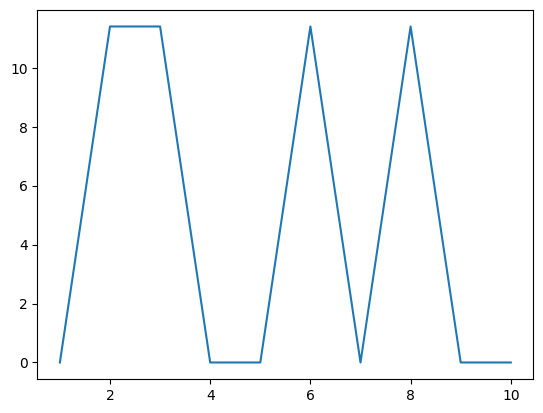

In [ ]:
num_episodes = 10

reward_histroy = []
losses = {'Actor Loss': [], 'Critic Loss': []}

for episode in tqdm(range(1, num_episodes+1)):
    
    # State initialization, this is the first state of the episode
    observation = env.reset() 
    episode_reward = 0
    done = False
    
    while not done:
        with tf.GradientTape(persistent = True) as tape:

            chef1_observation = observation['both_agent_obs'][0]
            chef2_observation = observation['both_agent_obs'][1]

            chef1_observation = tf.convert_to_tensor(chef1_observation, dtype = tf.float32)
            chef1_observation = keras.ops.expand_dims(chef1_observation, 0)

            chef2_observation = tf.convert_to_tensor(chef2_observation, dtype = tf.float32)
            chef2_observation = keras.ops.expand_dims(chef2_observation, 0)

            # Need to select an action A following our policy (given the state S)
            ## Predict the action probabilities
            chef1_action_probs = actor(chef1_observation)
            chef2_action_probs = actor(chef2_observation)

            ## Sample action given the action probability distribution
            chef1_action = np.random.choice(num_actions, p=np.squeeze(chef1_action_probs))
            chef2_action = np.random.choice(num_actions, p=np.squeeze(chef2_action_probs))
            
            # Apply the sampled action A in our environment, an observe new state S' and reward R
            next_observation, reward, done, info = env.step((int(chef1_action), int(chef2_action)))
            episode_reward += reward
            observation = next_observation
          
            # Lets convert to tensor all we need
            chef1_next_observation = next_observation['both_agent_obs'][0]
            chef2_next_observation = next_observation['both_agent_obs'][1]

            chef1_next_observation = tf.convert_to_tensor(chef1_next_observation, dtype = tf.float32)
            chef1_next_observation = keras.ops.expand_dims(chef1_next_observation, 0)

            chef2_next_observation = tf.convert_to_tensor(chef2_next_observation, dtype = tf.float32)
            chef2_next_observation = keras.ops.expand_dims(chef2_next_observation, 0)

            reward = tf.convert_to_tensor(reward, dtype='float32')

            # Compute losses
            ## Computing the advantage function
            ### Predict future rewards from present and future state 
            chef1_observation_value = critic(chef1_observation)
            chef2_observation_value = critic(chef2_observation)
            chef1_next_observation_value = critic(chef1_next_observation)
            chef2_next_observation_value = critic(chef2_next_observation)
            
            ### To compute the loss we need to get rid of the extra dimenion
            chef1_observation_value = tf.squeeze(chef1_observation_value)
            chef2_observation_value = tf.squeeze(chef2_observation_value)
            chef1_next_observation_value = tf.squeeze(chef1_next_observation_value)
            chef2_next_observation_value = tf.squeeze(chef2_next_observation_value)

            ### Target value
            chef1_target = reward + gamma*chef1_next_observation_value*(1-int(done))
            chef2_target = reward + gamma*chef2_next_observation_value*(1-int(done))
            
            ### Advantage function
            chef1_advantage = chef1_target - chef1_observation_value
            chef2_advantage = chef2_target - chef2_observation_value
            
            ## Actor loss
            ### Compute the log probabilities of the action
            chef1_log_prob = np.log(np.squeeze(chef1_action_probs)[chef1_action])
            chef2_log_prob = np.log(np.squeeze(chef2_action_probs)[chef2_action])

            ### Compute the loss
            chef1_actor_loss = -chef1_log_prob*chef1_advantage
            chef2_actor_loss = -chef2_log_prob*chef2_advantage
            actor_loss = (0.5)*chef1_actor_loss + (0.5)*chef2_actor_loss
            losses['Actor Loss'].append(actor_loss)
    
            ## Critic loss with MSE loss (==chef_advantage**2)
            chef1_critic_loss = mse_loss([chef1_observation_value], [chef1_target])
            chef2_critic_loss = mse_loss([chef2_observation_value], [chef2_target])
            critic_loss = (0.5)*chef1_critic_loss + (0.5)*chef2_critic_loss 
            losses['Critic Loss'].append(critic_loss)

        # Backpropagation for both Actor & Critic   
        actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
        critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
        
        actor_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
        critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
        
        del tape

    # Let collect the reward of this episode
    reward_histroy.append(episode_reward)
    # Update running reward to check condition for solving
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
    
    # Log details
    if (episode) % 5 == 0:
        template = "running reward: {:.2f} at episode {}"
        template2 = "Last actor Loss: {:.2f} - Last critic Loss: {:.2f}"
        print(template.format(running_reward, episode), template2.format(tf.squeeze(losses['Actor Loss'][-1]), tf.squeeze(losses['Critic Loss'][-1])))

# Plot the reward over the episodes
x = [i+1 for i in range(num_episodes)]
y = reward_histroy
plt.plot(x,y)
plt.show


#### <u>Update</u>: After each **n-step**

Sources: 
- https://medium.com/data-science-in-your-pocket/advantage-actor-critic-a2c-algorithm-in-reinforcement-learning-with-codes-and-examples-using-e810273c0c9e
- https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic


In [ ]:
num_episodes = 10
step_before_update = 128

reward_histroy = []
losses = {'Actor Loss': [], 'Critic Loss': []}

# Here we store all the values we need to update
replay_buffer = {
    'chef1_observations': [],
    'chef2_observations': [],
    'chef1_actions': [],
    'chef2_actions': [],
    'rewards': [],
    'chef1_next_observation_values': [],
    'chef2_next_observation_values': [],
    'dones': []
}

In [47]:
def update_networks(replay_buffer, actor, critic, actor_optimizer, critic_optimizer):
    chef1_observations = tf.stack(replay_buffer['chef1_observations'])
    chef2_observations = tf.stack(replay_buffer['chef2_observations'])
    chef1_actions = replay_buffer['chef1_actions']
    chef2_actions = replay_buffer['chef2_actions']
    rewards = replay_buffer['rewards']
    chef1_next_observation_values = replay_buffer['chef1_next_observation_values']
    chef2_next_observation_values = replay_buffer['chef2_next_observation_values']
    dones = replay_buffer['dones']

    # Compute the returns for each of the n-step
    chef1_returns = []
    chef2_returns = []

    for i in range(len(rewards)):
        n_step_return = 0
        for j in range(min(step_before_update, len(rewards) - i)):
            if dones[i + j]:
                n_step_return += (gamma ** j) * rewards[i + j]
                break
            n_step_return += (gamma ** j) * rewards[i + j]
        
        # Add discounted next value if episode didn't end
        if i + step_before_update < len(rewards) and not any(dones[i:i+step_before_update]):
            chef1_observation_value = critic(chef1_observation[i+step_before_update])
            chef1_observation_value = tf.squeeze(chef1_observation_value)
            n_step_return += (gamma ** step_before_update) * chef1_observation_value
        chef1_returns.append(n_step_return)
    
    for i in range(len(rewards)):
        n_step_return = 0
        for j in range(min(step_before_update, len(rewards) - i)):
            if dones[i + j]:
                n_step_return += (gamma ** j) * rewards[i + j]
                break
            n_step_return += (gamma ** j) * rewards[i + j]
        
        # Add discounted next value if episode didn't end
        if i + step_before_update < len(rewards) and not any(dones[i:i+step_before_update]):
            chef1_observation_value = critic(chef1_observation[i+step_before_update])
            chef1_observation_value = tf.squeeze(chef2_observation_value)
            n_step_return += (gamma ** step_before_update) * chef2_observation_value
        chef2_returns.append(n_step_return)
    
    chef1_returns = tf.convert_to_tensor(chef1_returns, dtype=tf.float32)
    chef2_returns = tf.convert_to_tensor(chef2_returns, dtype=tf.float32)

    chef1_advantages = chef1_returns - tf.squeeze(chef1_next_observation_values)
    chef2_advantages = chef2_returns - tf.squeeze(chef2_next_observation_values)


    with tf.GradientTape(persistent = True) as tape:
        # Forward pass
        chef1_action_probs = actor(chef1_observations)
        chef2_action_probs = actor(chef2_observations)
        chef1_predicted_values = critic(chef1_observations)
        chef2_predicted_values = critic(chef2_observations)
        
        # Actor loss
        chef1_action_dist = tfp.distributions.Categorical(probs=chef1_action_probs)
        chef2_action_dist = tfp.distributions.Categorical(probs=chef2_action_probs)
        
        chef1_log_probs = chef1_action_dist.log_prob(chef1_actions)
        chef2_log_probs = chef2_action_dist.log_prob(chef2_actions)
        
        # Policy gradient loss
        chef1_actor_loss = -tf.reduce_mean(chef1_log_probs * chef1_advantages)
        chef2_actor_loss = -tf.reduce_mean(chef2_log_probs * chef2_advantages)
        
        # Add entropy bonus to encourage exploration
        chef1_entropy = -tf.reduce_mean(chef1_action_dist.entropy())
        chef2_entropy = -tf.reduce_mean(chef2_action_dist.entropy())
        entropy_bonus = 0.01  # Hyperparameter
        
        actor_loss = 0.5 * (chef1_actor_loss + chef2_actor_loss) + entropy_bonus * (chef1_entropy + chef2_entropy)
        
        # Critic loss
        chef1_critic_loss = tf.reduce_mean(tf.square(chef1_returns - tf.squeeze(chef1_predicted_values)))
        chef2_critic_loss = tf.reduce_mean(tf.square(chef2_returns - tf.squeeze(chef2_predicted_values)))
        critic_loss = 0.5 * (chef1_critic_loss + chef2_critic_loss) 
    
    # Update networks
    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    
    # Clip gradients to prevent exploding gradients
    actor_grads = [tf.clip_by_norm(grad, 0.5) for grad in actor_grads]
    critic_grads = [tf.clip_by_norm(grad, 0.5) for grad in critic_grads]
    
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    del tape

    return actor_loss, critic_loss

  1%|          | 1/100 [00:16<26:28, 16.05s/it]

Soup delivered! Voto: 20


  5%|▌         | 5/100 [01:30<28:17, 17.87s/it]

Episode 5: running reward: 2.92
Actor Loss: 2.8659 - Critic Loss: 10.1453


 10%|█         | 10/100 [02:58<26:24, 17.61s/it]

Episode 10: running reward: 3.37
Actor Loss: -0.1037 - Critic Loss: 0.0042


 15%|█▌        | 15/100 [04:25<24:39, 17.40s/it]

Episode 15: running reward: 3.59
Actor Loss: -0.0972 - Critic Loss: 0.0025


 20%|██        | 20/100 [05:50<22:51, 17.14s/it]

Episode 20: running reward: 4.79
Actor Loss: -0.1466 - Critic Loss: 0.0044


 25%|██▌       | 25/100 [07:14<21:00, 16.80s/it]

Episode 25: running reward: 4.19
Actor Loss: -0.1255 - Critic Loss: 0.0034


 30%|███       | 30/100 [08:37<19:08, 16.41s/it]

Episode 30: running reward: 4.71
Actor Loss: -0.1682 - Critic Loss: 0.0070


 31%|███       | 31/100 [08:53<18:46, 16.33s/it]

Soup delivered! Voto: 20


 35%|███▌      | 35/100 [09:58<17:33, 16.20s/it]

Episode 35: running reward: 6.57
Actor Loss: -0.1694 - Critic Loss: 0.0071


 38%|███▊      | 38/100 [10:48<16:57, 16.40s/it]

Soup delivered! Voto: 20


 40%|████      | 40/100 [11:19<16:07, 16.12s/it]

Episode 40: running reward: 7.66
Actor Loss: -0.1293 - Critic Loss: 0.0055


 45%|████▌     | 45/100 [12:39<14:34, 15.90s/it]

Episode 45: running reward: 5.93
Actor Loss: -0.1208 - Critic Loss: 0.0040


 48%|████▊     | 48/100 [13:26<13:44, 15.85s/it]

Soup delivered! Voto: 20


 50%|█████     | 50/100 [13:58<13:10, 15.81s/it]

Episode 50: running reward: 7.65
Actor Loss: -0.1116 - Critic Loss: 0.0031


 54%|█████▍    | 54/100 [15:01<12:08, 15.84s/it]

Soup delivered! Voto: 20


 55%|█████▌    | 55/100 [15:20<12:34, 16.76s/it]

Episode 55: running reward: 8.96
Actor Loss: -0.1433 - Critic Loss: 0.0044
Soup delivered! Voto: 20


 60%|██████    | 60/100 [16:49<11:12, 16.80s/it]

Episode 60: running reward: 10.79
Actor Loss: -0.2548 - Critic Loss: 0.0273


 63%|██████▎   | 63/100 [17:37<09:56, 16.13s/it]

Soup delivered! Voto: 20


 64%|██████▍   | 64/100 [17:52<09:35, 16.00s/it]

Soup delivered! Voto: 20


 65%|██████▌   | 65/100 [18:08<09:17, 15.92s/it]

Episode 65: running reward: 12.41
Actor Loss: -0.1007 - Critic Loss: 0.0023


 66%|██████▌   | 66/100 [18:24<09:01, 15.92s/it]

Soup delivered! Voto: 20
Soup delivered! Voto: 20


 70%|███████   | 70/100 [19:30<08:14, 16.47s/it]

Episode 70: running reward: 13.83
Actor Loss: -0.2800 - Critic Loss: 0.0206


 71%|███████   | 71/100 [19:46<07:52, 16.31s/it]

Soup delivered! Voto: 20


 74%|███████▍  | 74/100 [20:33<06:55, 15.96s/it]

Soup delivered! Voto: 20


 75%|███████▌  | 75/100 [20:49<06:38, 15.93s/it]

Episode 75: running reward: 14.62
Actor Loss: -0.1426 - Critic Loss: 0.0046


 76%|███████▌  | 76/100 [21:08<06:38, 16.62s/it]

Soup delivered! Voto: 20


 77%|███████▋  | 77/100 [21:24<06:19, 16.48s/it]

Soup delivered! Voto: 20


 78%|███████▊  | 78/100 [21:40<05:59, 16.33s/it]

Soup delivered! Voto: 20


 80%|████████  | 80/100 [22:13<05:26, 16.35s/it]

Episode 80: running reward: 16.55
Actor Loss: -0.1748 - Critic Loss: 0.0088


 85%|████████▌ | 85/100 [23:32<03:58, 15.92s/it]

Episode 85: running reward: 15.90
Actor Loss: -0.2615 - Critic Loss: 0.0241


 90%|█████████ | 90/100 [24:50<02:36, 15.65s/it]

Episode 90: running reward: 14.88
Actor Loss: -0.1892 - Critic Loss: 0.0120


 93%|█████████▎| 93/100 [25:37<01:48, 15.57s/it]

Soup delivered! Voto: 20


 94%|█████████▍| 94/100 [25:53<01:33, 15.62s/it]

Soup delivered! Voto: 20


 95%|█████████▌| 95/100 [26:10<01:20, 16.03s/it]

Episode 95: running reward: 15.20
Actor Loss: -0.2613 - Critic Loss: 0.0204


 96%|█████████▌| 96/100 [26:25<01:03, 15.93s/it]

Soup delivered! Voto: 20


100%|██████████| 100/100 [27:28<00:00, 16.49s/it]

Episode 100: running reward: 15.20
Actor Loss: -0.2491 - Critic Loss: 0.0201


<function matplotlib.pyplot.show(close=None, block=None)>

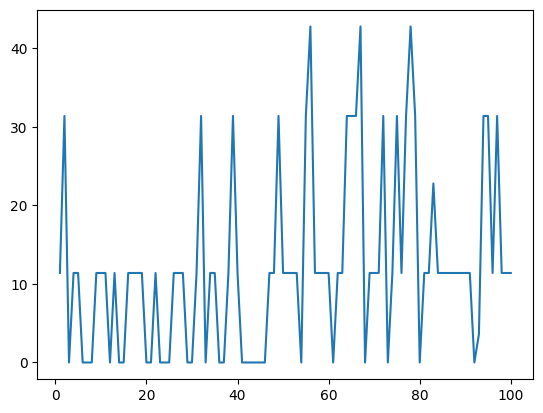

In [48]:
for episode in tqdm(range(1, num_episodes+1)):
    # We initialize the state S
    observation = env.reset()
    episode_reward = 0
    done = False
    timestep = 0
    
    while not done:
        # Each chef has its own observation
        chef1_observation = tf.convert_to_tensor(observation['both_agent_obs'][0], dtype = tf.float32)
        chef2_observation = tf.convert_to_tensor(observation['both_agent_obs'][1], dtype = tf.float32)
        chef1_observation = keras.ops.expand_dims(chef1_observation, 0)
        chef2_observation = keras.ops.expand_dims(chef2_observation, 0)

        # Action selection & State value - Using ACTOR
        # Predict action probabilities from present state
        chef1_action_probs = actor(chef1_observation)
        chef2_action_probs = actor(chef2_observation)

        # Sample action from action probability distribution
        chef1_action_prob_dist = tfp.distributions.Categorical(probs=chef1_action_probs)
        chef2_action_prob_dist = tfp.distributions.Categorical(probs=chef2_action_probs)
        chef1_action = chef1_action_prob_dist.sample()
        chef2_action = chef2_action_prob_dist.sample()

        # Apply the sampled action in our environment
        next_observation, reward, done, info = env.step((int(chef1_action), int(chef2_action)))
        episode_reward += reward
        
        # These are the new observation, after the action just taken
        chef1_next_observation = tf.convert_to_tensor([next_observation['both_agent_obs'][0]], dtype = tf.float32)
        chef2_next_observation = tf.convert_to_tensor([next_observation['both_agent_obs'][1]], dtype = tf.float32)

        # Predict future rewards from environment state
        chef1_next_observation_value = critic(chef1_next_observation)
        chef2_next_observation_value = critic(chef2_next_observation)
        
        # Convert reward into a Tensor before loading it inside the buffer
        reward = tf.convert_to_tensor([reward], dtype='float32')        
        
        # Store experience inside the buffer 
        replay_buffer['chef1_observations'].append(tf.squeeze(chef1_observation))
        replay_buffer['chef2_observations'].append(tf.squeeze(chef2_observation))
        replay_buffer['chef1_actions'].append(chef1_action)
        replay_buffer['chef2_actions'].append(chef2_action)
        replay_buffer['rewards'].append(reward)
        replay_buffer['chef1_next_observation_values'].append(tf.squeeze(chef1_next_observation_value))
        replay_buffer['chef2_next_observation_values'].append(tf.squeeze(chef2_next_observation_value))
        replay_buffer['dones'].append(done)

        observation = next_observation
        timestep += 1

        # Update the networks every n-step or at the end of the episode
        if len(replay_buffer['rewards']) >= step_before_update or done:
            actor_loss, critic_loss = update_networks(replay_buffer, actor, critic, actor_optimizer, critic_optimizer)
        
            # Clear buffer
            for key in replay_buffer:
                replay_buffer[key] = []
            
            # Store losses
            losses['Actor Loss'].append(actor_loss)
            losses['Critic Loss'].append(critic_loss)

    # Let collect the reward of this episode
    reward_histroy.append(episode_reward)
    # Update running reward to check condition for solving
    running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

    # Log details
    if episode % 5 == 0:
        template = "Episode {}: running reward: {:.2f}"
        print(template.format(episode, running_reward))
        if losses['Actor Loss']:  # Check if we have losses to report
            template2 = "Actor Loss: {:.4f} - Critic Loss: {:.4f}"
            print(template2.format(float(losses['Actor Loss'][-1]), float(losses['Critic Loss'][-1])))

# Plot the reward over the episodes
x = [i+1 for i in range(num_episodes)]
y = reward_histroy
plt.plot(x,y)
plt.show


### Test for Visualization

In [19]:
import pygame

# 1) Initialize Pygame & Visualizer
pygame.init()
visualizer = StateVisualizer()

# 2) Grab your grid and do one dummy render to get a surface
grid = base_env.mdp.terrain_mtx
_ = env.reset()
surf = visualizer.render_state(base_env.state, grid=grid)

# 3) Use that surface’s size for your window
win_w, win_h = surf.get_size()
screen = pygame.display.set_mode((win_w, win_h), pygame.RESIZABLE)
clock  = pygame.time.Clock()

# 4) Main loop: render each frame & blit into the same window
running = True
observation = env.reset() #observation of the starting state
soup_delivered = 0

while running:
    for ev in pygame.event.get():
        if ev.type == pygame.QUIT:
            running = False
    
    # observation of the environment
    chef1_observation = observation['both_agent_obs'][0]
    chef2_observation = observation['both_agent_obs'][1]

    chef1_observation = keras.ops.convert_to_tensor(chef1_observation)
    chef1_observation = keras.ops.expand_dims(chef1_observation, 0)

    chef2_observation = keras.ops.convert_to_tensor(chef2_observation)
    chef2_observation = keras.ops.expand_dims(chef2_observation, 0)
    
    # step the environment
    chef1_action_probs = actor(chef1_observation)
    chef1_action = np.random.choice(num_actions, p=np.squeeze(chef1_action_probs))
    
    chef2_action_probs = actor(chef2_observation)
    chef2_action = np.random.choice(num_actions, p=np.squeeze(chef2_action_probs))

    # try to step; if episode is over, catch and reset
    try:
        # Overcooked wrapper returns (obs_p0, obs_p1, reward, done, info)
        observation, reward, done, info = env.step((chef1_action, chef2_action))
        if reward > 19:
            soup_delivered += 1
    except AssertionError:
        # base_env.is_done() was True → reset and continue
        env.reset()
        break

    # render the new state
    surf = visualizer.render_state(base_env.state, grid=grid)

    # draw it
    screen.blit(surf, (0, 0))
    pygame.display.flip()

    clock.tick(15)   # cap at 30 FPS

pygame.quit()

print(f"Soup delivered: {soup_delivered}")


Soup delivered: 0
